In [1]:
import imp
import os

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly

from BuildingControlSimulator.Simulator.Simulation import Simulation
from BuildingControlSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlSimulator.ControlModels.Deadband import Deadband

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2

In [2]:
s = Simulation(
    building_model=EnergyPlusBuildingModel(
        idf=IDFPreprocessor(
            idf_name=f"Zone5VAV-Pri-SecLoop_{os.environ['ENERGYPLUS_INSTALL_VERSION']}.idf",
            init_temperature=25.),
        weather_name="USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw"
    ),
    controller=Deadband(deadband=1., stp_heat=21., stp_cool=25.),
    step_size_minutes=5,
    start_time_days = 204,
    final_time_days = 209,
)

IDFPreprocessor loading .idf file: /root/home/lib/building-control-simulator/idf/v8-9-0/Zone5VAV-Pri-SecLoop_8-9-0.idf


In [3]:
%time s.initialize()

CPU times: user 104 ms, sys: 39.9 ms, total: 144 ms
Wall time: 11 s


In [4]:
%time output_df = s.run()

CPU times: user 1.07 s, sys: 88.6 ms, total: 1.16 s
Wall time: 2.93 s


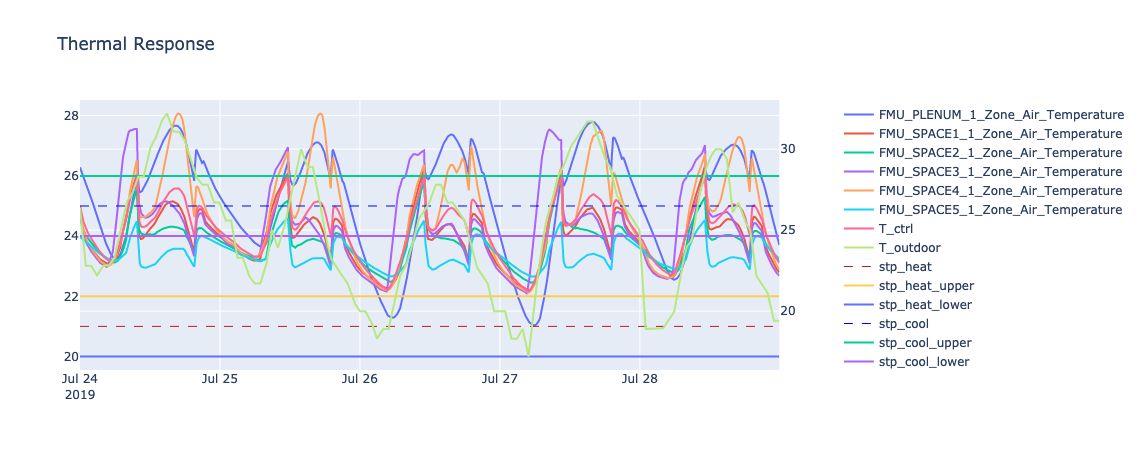

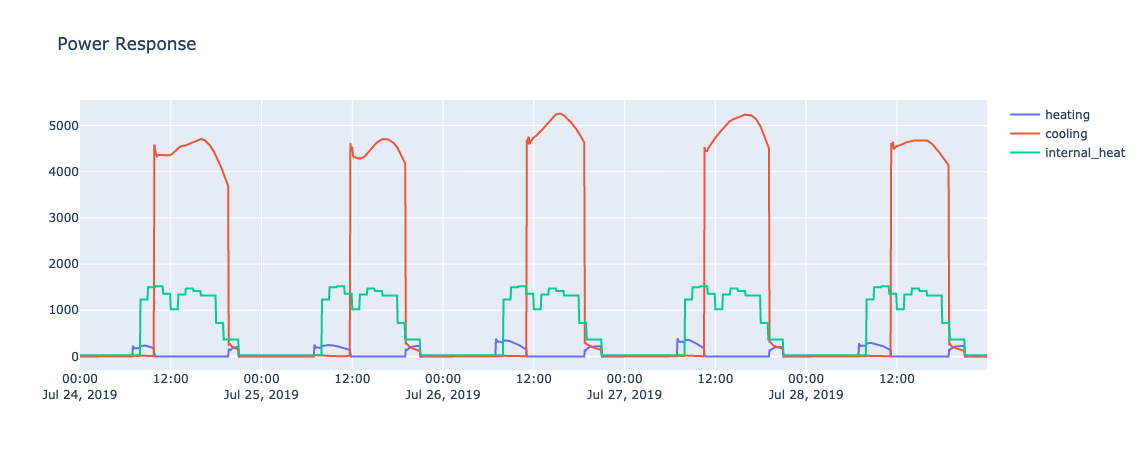

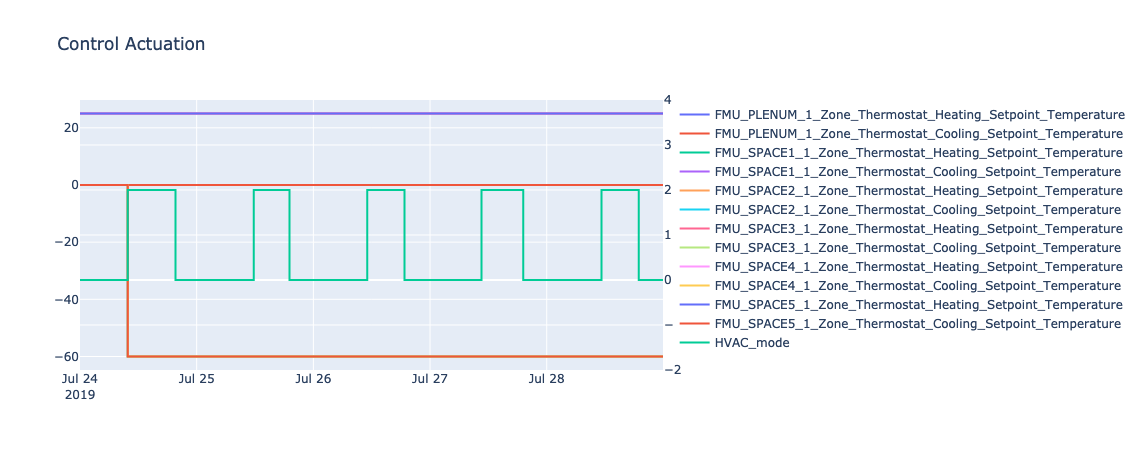

CPU times: user 2.83 s, sys: 55.2 ms, total: 2.89 s
Wall time: 2.9 s


In [5]:
%time s.show_plots()